In [1]:
]activate ../.

 Activating environment at `~/Documents/Julia/SEM/SEM.jl/Project.toml`


In [2]:
using Revise
using SEM
using LinearAlgebra, Plots, UnPack, Setfield
using Zygote, Flux
using Statistics

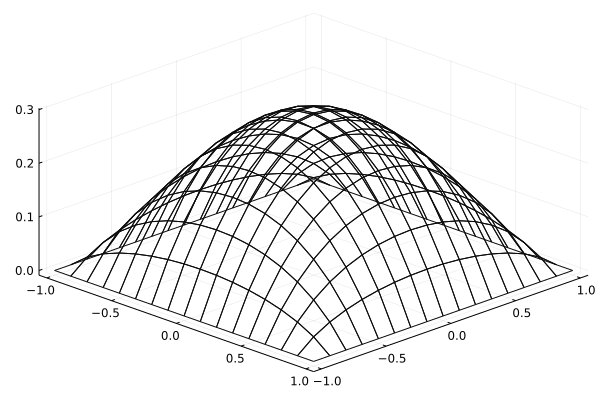

In [3]:
Ex = 16; nr1 = 2;
Ey = 16; ns1 = 2;

ifperiodic = [false,false]
m1 = Mesh(nr1,ns1,Ex,Ey,ifperiodic)
bc = ['D','D','D','D']

setIC(u,x,y,t) = 0.0 .*u
setBC(ub,x,y,t) = @. 0+0*x
setForcing(f,x,y,t) = @. 1+0*x
setVisc(ν,x,y,t) = @. 1+0*x

sch = DiffusionScheme(setIC,setBC,setForcing,setVisc)
dfn = Diffusion(bc,m1,sch,Tf=0.0,dt=0.00)

sim!(dfn)
utrue = dfn.fld.u

meshplt(utrue,m1)

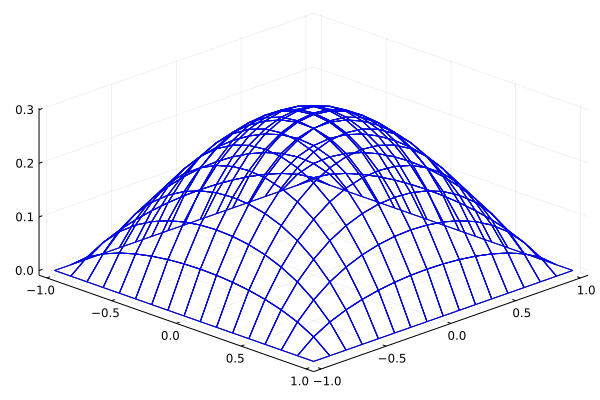

loss() = 2.3203416233173405e-9


2.3203416233173405e-9

In [4]:
# Learn ν #

p0_ν = [2.]
learnVisc(ν,x,y,t) = @. p0_ν+0*x

sch_ν = @set sch.setVisc = learnVisc
dfn_ν = Diffusion(bc,m1,sch_ν,Tf=0.0,dt=0.00)

function model()
    sim!(dfn_ν)
    upred = dfn_ν.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss()
    plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_ν])
opt = ADAM(1e-2)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.5))
plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()

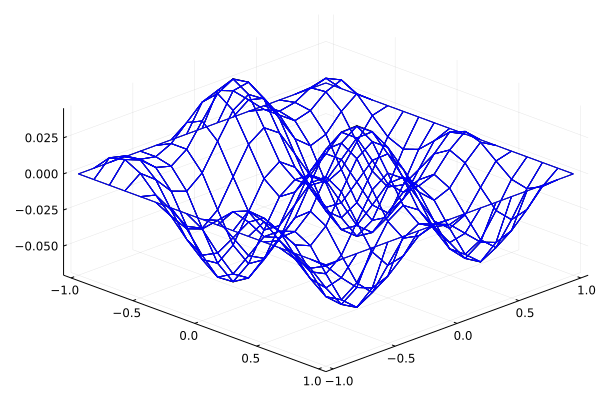

loss() = 4.384377555525037e-9


4.384377555525037e-9

In [5]:
# Learn f #

sinForcing(f,x,y,t) = @. sin(2*pi*x)+cos(2*pi*y)
sch2 = @set sch.setForcing = sinForcing
dfn = Diffusion(bc,m1,sch2,Tf=0.0,dt=0.00)

sim!(dfn)
utrue2 = dfn.fld.u

p0_f = .1 .*ones(size(dfn.f)...)
learnForce(f,x,y,t) = p0_f

sch_f = @set sch.setForcing = learnForce
dfn_f = Diffusion(bc,m1,sch_f,Tf=0.0,dt=0.00)

function model()
    sim!(dfn_f)
    upred = dfn_f.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue2)
end

function cb()
    @show loss()
    plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_f])
opt = ADAM(5e-2)
Flux.train!(loss,ps,Iterators.repeated((), 500),opt, cb = Flux.throttle(cb,1))
plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()

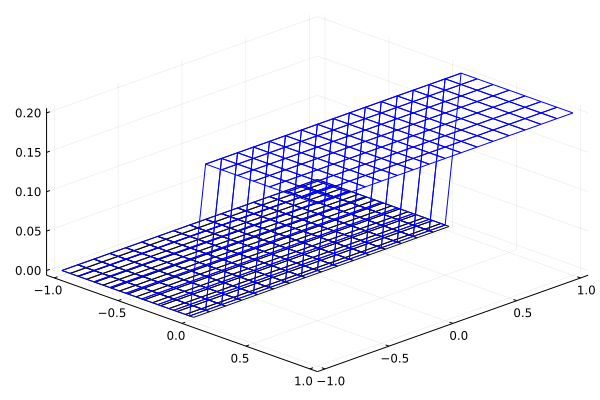

loss() = 0.0


0.0

In [6]:
# Learn mesh #

stepForcing(f,x,y,t) = @. 1*(x>0) + 0*x
sch_m = @set sch.setForcing = stepForcing

b = [1.]
function deform(x,y)
    x = x.*(b.+1)./2 .-(-(b.+1)./2 .+1)
    return x,y
end

function model()
    m2 = Mesh(nr1,ns1,Ex,Ey,ifperiodic,deform)
    dfn_m = Diffusion(bc,m2,sch_m,Tf=0.0,dt=0.00)
    sim!(dfn_m)
    upred = dfn_m.fld.u
    return upred, m2, dfn_m
end

function loss()
    upred = model()[1]
    sum(abs2,upred)
end

function cb()
    @show loss()
    up,m,d = model()
    plt = meshplt(up,m); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([b])
opt = ADAM(5e-3)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.2))
opt = ADAM(2e-2)
Flux.train!(loss,ps,Iterators.repeated((), 50),opt, cb = Flux.throttle(cb,.2))
up,m,d = model()
plt = meshplt(up,m); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:blue); display(plt) 
@show loss()


In [7]:
l2g(u,msh) = ABu(msh.Qy',msh.Qx',msh.mult.*u)
g2l(u,msh) = ABu(msh.Qy,msh.Qx,u)

g2l (generic function with 1 method)

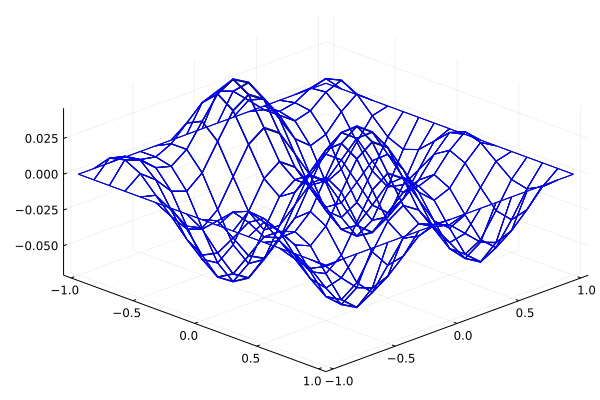

loss(test_data...) = 6.168234558258909e-8
kernel = 
  0.007441978435963392  -1.0032484531402588   0.007441978435963392
 -1.0019049644470215     3.987467050552368   -1.0019049644470215
  0.005535375326871872  -1.0058035850524902   0.005535375326871872

In [19]:
# Learn laplace #

oper = Conv((3,3),1=>1,pad=1,stride=1,bias=false)
oper.weight[:,:,1,1].=-[0 1 0;1 -4 1;0 1 0].+1
p0_lap,re_lap = Flux.destructure(oper)

function lapLearn(dfn::Diffusion)
    
    function opL(u,p0_lap,ν,msh)
        lhs = u.*ν
        lhs = l2g(lhs,msh)
        lhs = re_lap(p0_lap)(reshape(lhs,size(lhs)...,1,1))[:,:,1,1]
        lhs = g2l(lhs,msh).*msh.mult
        return lhs
    end
    
    return opL, (p0_lap,dfn.ν,dfn.msh)
end

function trueU(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    s = @set sch.setForcing = varForcing
    d = Diffusion(bc,m1,s,Tf=0.0,dt=0.00)
    sim!(d)
    utrue = d.fld.u
end

function model(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    sch_lap = @set sch.opLHS = lapLearn
    sch_lap = @set sch_lap.setForcing = varForcing
    dfn_lap = Diffusion(bc,m1,sch_lap,Tf=0.0,dt=0.00)
    sim!(dfn_lap)
    upred = dfn_lap.fld.u
end

function loss(data...)
    upred = model(data...)
    utrue = trueU(data...)
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss(test_data...)
    plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue);
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_lap])
data = [(rand(),rand()) for i=1:1000]
test_data = (1,1)
opt = ADAM(1e-3)
Flux.train!(loss,ps,data,opt, cb = Flux.throttle(cb,2))
plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue); display(plt)
@show loss(test_data...)
println("kernel = ")
Base.print_matrix(stdout, re_lap(p0_lap).weight[:,:,1,1].|>Float64)

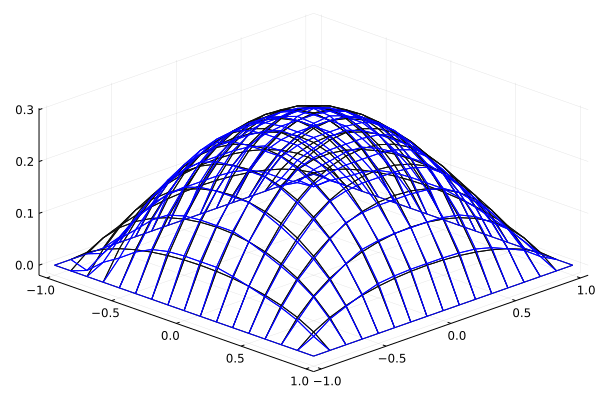

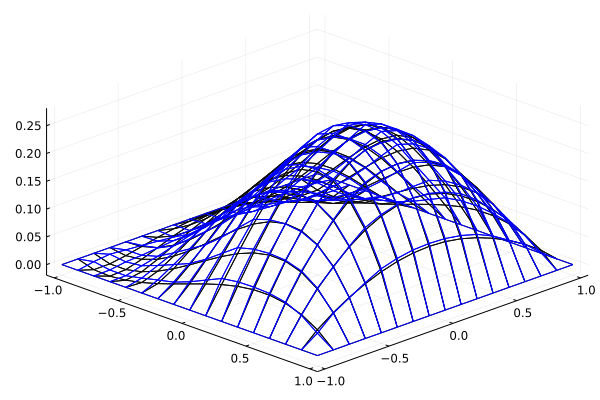

loss(test_data...) = 7.833575525501451e-5
loss(0.3, 0.3) = 4.405414735100834e-5


4.405414735100834e-5

In [49]:
# Learn solution op

m = Chain(Conv((3,3),1=>32,pad=1,stride=1,swish),
        #   Conv((3,3),32=>32,pad=1,stride=1,swish),
        #   Conv((3,3),32=>32,pad=1,stride=1,swish),
        #   Conv((3,3),32=>32,pad=1,stride=1,swish),
        #   Conv((3,3),32=>32,pad=1,stride=1,swish),
          Conv((3,3),32=>1,pad=1,stride=1))
p0_so,re_so = Flux.destructure(m)

function opLearn!(dfn::Diffusion)
    @unpack rhs,ν,msh,fld = dfn
    @unpack u,ub = fld

    rhs = l2g(rhs./ν,msh)
    u = re_so(p0_so)(reshape(rhs,size(rhs)...,1,1))[:,:,1,1]
    u = g2l(u,msh)
    u = mask(u,fld.M)

    u = u + ub
    @pack! dfn.fld = u
    return
end

sch_so = @set sch.solve! = opLearn!
dfn_so = Diffusion(bc,m1,sch_so,Tf=0.0,dt=0.00)

function model(a,b)
    varForcing(f,x,y,t) = @. sin(2*pi*x*a)+cos(2*pi*y*b)
    sch_so = @set sch.solve! = opLearn!
    sch_so = @set sch_so.setForcing = varForcing
    dfn_so = Diffusion(bc,m1,sch_so,Tf=0.0,dt=0.00)
    sim!(dfn_so)
    upred = dfn_so.fld.u
end

function loss(data...)
    upred = model(data...)
    utrue = trueU(data...)
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss(test_data...)
    plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue);
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_so])
test_data = (.0,.0)
data = [(.3*rand(),.3*rand()) for i=1:1000]
# data = Iterators.repeated(test_data,500)
opt = ADAM(1e-3)
Flux.train!(loss,ps,data,opt, cb = Flux.throttle(cb,2))
plt = meshplt(trueU(test_data...),m1); plt = meshplt!(m1.x,m1.y,model(test_data...),c=:blue); display(plt)
@show loss(test_data...)

plt = meshplt(trueU(.3,.3),m1); plt = meshplt!(m1.x,m1.y,model(.3,.3),c=:blue); display(plt)
@show loss(.3,.3)
